In [161]:
import numpy as np
from matplotlib import pyplot as plt
from Bio import Phylo
from Bio.Seq import Seq
import random
import string
from Bio.Phylo.BaseTree import Tree, Clade
from itertools import product
from keras.utils import to_categorical
import copy

# Root: MRCA (Most Recent Common Ancestor) of all known given present known taxa ("terminal" taxa of "leaves")
# Parent: "parent" node, given an edge
# Child/children: "children" nodes or "child" node, given an edge 
# Ancestor: any node along the chain of parents, starting from a node 
# Descendant: any node belonging to a clade, starting from a node
# Terminal: "leaf" nodes in the tree

seed = 3
random.seed(seed)
np.random.seed(seed)

# Define bases
purines = ["A", "G"]
pyrimidines = ["C", "T"]
bases = purines + pyrimidines
n_bases = len(bases)

def index_to_sequence(idx):
    seq = "".join([bases[i] for i in idx])
    return seq

def sequence_to_index(seq):
    idx = []
    for base in seq:
        idx.append(np.where(np.array(bases) == base)[0][0])
    idx = np.array(idx)
    return idx

def generate_sequence(seq_len, prob=None):
    if prob is None:
        idx = np.random.randint(0, n_bases, size=seq_len)
    else:
        idx = np.random.choice(len(prob), size=seq_len, p=prob)
    seq = index_to_sequence(idx)
    return seq

# Jukes-Cantor substitution model
def Markov_matrix(alpha, edge_len):
    a = 3 / 4 * (1 - np.exp(-4 / 3 * alpha * edge_len))
    M = (a / 3 *  np.ones((n_bases, n_bases)) + (1 - 4 / 3 * a) * np.diag(np.ones(n_bases)))
    return M

def Markov_process(p_init, transition_matrix):
    p_final = p_init @ transition_matrix
    return p_final

def generate_child_from_parent(parent, alpha, edge_len): # can accept either sequence or indices
    seq_len = len(parent)

    if type(parent) == str:
        parent_idx = sequence_to_index(parent)
    else:
        parent_idx = parent
    parent_prob = to_categorical(parent_idx, num_classes=n_bases) # one-hot encoding
    M = Markov_matrix(alpha, edge_len)
    child_prob = Markov_process(parent_prob, M)
    child_seq = "".join([generate_sequence(1, prob=child_prob[i])[0] for i in range(seq_len)])
    return child_seq

def count_mutations(parent_seq, child_seq):
    n_mutations = sum(x != y for x, y in zip(parent_seq, child_seq))
    return n_mutations

In [162]:
class Phylogenetic_Tree(Phylo.BaseTree.Tree):
    def __init__(self, seq_len, alpha, root=None, rooted=True):  
        super().__init__(root=root, rooted=rooted)
        self.seq_len = seq_len
        self.alpha = alpha
        self.root.name = "Root"
        self.children = self.dict_children()
        self.parents = self.dict_parents()
        self.siblings = self.dict_siblings()
        self.n_taxa = len(self.get_terminals())
        self.taxa_names = [node.name for node in self.get_terminals()]
        self.adjust_branch_lengths()

    @classmethod
    def read_from_file(cls, file_path, generate_sequences=True):
        tree = Phylo.read(file_path, "newick")
        instance = cls(seq_len=seq_len, alpha=alpha, root=tree.clade)
        if generate_sequences:
            instance.generate_sequences_for_whole_tree()
        return instance
    
    @classmethod
    def generate_random_tree(cls, n_taxa=None, taxa_names=None, generate_sequences=True):
        if taxa_names is None: # generate tree from a random number of randomly named taxa
            if n_taxa is None:
                n_taxa = np.random.randint(4,100)
            taxa_names = [f"S{i}" for i in range(n_taxa)]
        
        else: # generate tree from predefined terminal taxa
            if n_taxa:
                print(f"Parameter n_taxa = {n_taxa} is redundant")
            n_taxa = len(taxa_names)

        tree = Tree().randomized(taxa_names, branch_length=None)
        instance = cls(seq_len=seq_len, alpha=alpha, root=tree.clade)
        if generate_sequences:
            instance.generate_sequences_for_whole_tree()
        return instance

    def dict_children(self): # init
        children = {clade:clade.clades for clade in self.find_clades(order="level") if clade.clades}
        return children

    def dict_parents(self): # init
        parents = {child:parent for parent in self.find_clades(order="level") for child in parent.clades}
        return parents
    
    def dict_siblings(self): # init
        siblings = {clade:sibling for clade in self.find_clades(order="level") if clade != self.root for sibling in self.parents.get(clade).clades if sibling != clade}
        return siblings

    def adjust_branch_lengths(self): # init
        for clade in self.find_clades():
            if clade != self.root and (clade.branch_length == 0 or clade.branch_length is None):
                clade.branch_length = np.random.randint(1,10) / 10

        distances_from_root = [(clade.name, self.distance(clade)) for clade in self.find_clades()]
        present = max(distances_from_root, key=lambda x: x[1])[1]

        for terminal_clade in self.get_terminals():
            if terminal_clade == self.root:
                continue
            parent = self.parents.get(terminal_clade)
            terminal_clade.branch_length = np.round(present - self.distance(parent), decimals=5)

    def generate_sequences_for_whole_tree(self): # init
        for parent, children in self.children.items():
            if parent == self.root:
                parent.sequence = generate_sequence(self.seq_len)
            for child in children:
                child.sequence = generate_child_from_parent(parent.sequence, self.alpha, child.branch_length)
                child.mutations = count_mutations(parent.sequence, child.sequence)

    # Felsenstein pruning algorithm
    def calculate_likelihood(self, p_root=np.ones(n_bases)/n_bases, log=False):
        for parent, children in reversed(self.children.items()):
            for child in children:
                if child.is_terminal():
                    child.C = to_categorical(sequence_to_index(child.sequence), num_classes=n_bases)
                child.W = Markov_matrix(self.alpha, child.branch_length) @ child.C.T
            parent.C = (np.multiply(children[0].W, children[1].W)).T

        joint_prob = p_root @ self.root.C.T
        likelihood = np.prod(joint_prob)
        if log:
            log_likelihood = np.sum(np.log(joint_prob))
            return likelihood, log_likelihood
        else: 
            return likelihood
        
    def draw(self, figsize=(12,6)):
        _, ax = plt.subplots(figsize=figsize)
        Phylo.draw(self, axes=ax)

    def write(self, file):
        Phylo.write(self, file, "newick")

    # Nearest Neighbor Interchange (NNI) methods
    def NNI_eligible_nodes(self):
        i = 0
        NNI_nodes = []
        for node in self.get_nonterminals(order="postorder"):
            if node == self.root: continue
            elif self.parents.get(node) == self.root:
                i += 1
                if i == 2: # If root node has two children within the nonterminals, then I skip the first one and get only the second one. 
                    NNI_nodes.append(node)
            else:
                NNI_nodes.append(node)

        assert self.n_taxa-3 == len(NNI_nodes) 
        return NNI_nodes

    def NNI_permutable_nodes(self, chosen_node): # 3 nodes that can be permuted in a rooted tree NNI step
        permutable = [] # keep this otherwise error
        permutable += self.children.get(chosen_node)
        sibling = self.siblings.get(chosen_node)
        if self.parents.get(chosen_node) == self.root:
            niblings = self.children.get(sibling)
            permutable.append(niblings[0])
        else:
            permutable.append(sibling)
        assert len(permutable) == 3 
        return permutable

In [163]:
# # Generate a tree from file.

# seq_len = 5
# alpha = 0.5

# file_path = "Trees\\"
# file_name = "tree_basic.dnd"

# tree_basic = Phylogenetic_Tree(seq_len, alpha).read_from_file(file_path + file_name)
# print(tree_basic)
# print(f"Likelihood: {tree_basic.calculate_likelihood()}")
# tree_basic.draw()

In [164]:
# # Generate a random tree and write to file

# seq_len = 6
# alpha = 0.5
# n_taxa = 10

# tree_random = Phylogenetic_Tree(seq_len, alpha).generate_random_tree(n_taxa=n_taxa, generate_sequences=True)
# print(tree_random)
# print(f"Likelihood: {tree_random.calculate_likelihood()}")
# tree_random.draw(figsize=(12,10))

# file_name = "tree_random.dnd"
# tree_random.write(file_path + file_name)

### Explore tree space and evaluate posterior for tree

Phylogenetic_Tree(alpha=0.1, n_taxa=5, rooted=True, seq_len=10)
    Clade(name='Root', sequence='TCAAAGTCAC')
        Clade(branch_length=0.9, mutations=0, name='n0', sequence='TCAAAGTCAC')
            Clade(branch_length=0.4, mutations=0, name='n00', sequence='TCAAAGTCAC')
                Clade(mutations=1, name='S2', sequence='GCAAAGTCAC')
                Clade(branch_length=0.9, mutations=1, name='n001', sequence='TCAAACTCAC')
                    Clade(mutations=0, name='S0', sequence='TCAAACTCAC')
                    Clade(mutations=0, name='S4', sequence='TCAAACTCAC')
            Clade(mutations=1, name='S3', sequence='TCGAAGTCAC')
        Clade(mutations=3, name='S1', sequence='CCGAAGTTAC')
Likelihood: 8.231268078408486e-17


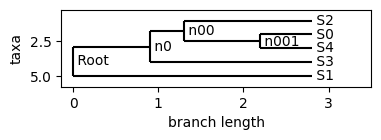

In [165]:
# Generate a small random tree (4 taxa) and write to file

seq_len = 10
alpha = 0.1
n_taxa = 5

original_tree = Phylogenetic_Tree(seq_len, alpha).generate_random_tree(n_taxa=n_taxa, generate_sequences=True)
print(original_tree)
print(f"Likelihood: {original_tree.calculate_likelihood()}")
original_tree.draw(figsize=(4,1))
# file_name = "tree_4taxa.xml"
# Phylo.write(tree, file_path + file_name, "phyloxml")

terminal_taxa = copy.deepcopy(original_tree.get_terminals()) # My data

Phylogenetic_Tree(n_taxa=5, rooted=True, seq_len=10)
    Clade(name='Root')
        Clade(name='S2', sequence='GCAAAGTCAC')
        Clade(branch_length=0.5, name='n1')
            Clade(branch_length=0.3, name='n10')
                Clade(name='S3', sequence='TCAAACTCAC')
                Clade(name='S0', sequence='TCAAACTCAC')
            Clade(branch_length=0.8, name='n11')
                Clade(name='S1', sequence='TCGAAGTCAC')
                Clade(name='S4', sequence='CCGAAGTTAC')


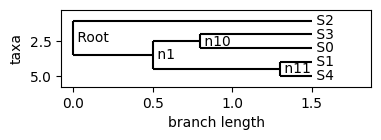

In [166]:
alpha_interval = np.array([0.05, 0.15])
alpha = np.random.randint(0,10) * (alpha_interval[1] - alpha_interval[0]) / 10 + alpha_interval[0]

taxa_names = [clade.name for clade in terminal_taxa]
taxa_sequences = [clade.sequence for clade in terminal_taxa]

tree = Phylogenetic_Tree(seq_len, alpha).generate_random_tree(taxa_names=taxa_names, generate_sequences=False)
for i, clade in enumerate(tree.get_terminals()):
    clade.sequence = taxa_sequences[i]
print(tree)
tree.draw(figsize=(4,1))

In [167]:
NNI_nodes = tree.NNI_eligible_nodes()
print(f"Internal edges: {[node.name for node in NNI_nodes]}")

chosen_node = random.choice(NNI_nodes)
print(f"Chosen node: {chosen_node}")

permutable = tree.NNI_permutable_nodes(chosen_node)
print(f"Nodes to be permuted: {[node.name for node in permutable]}")

Internal edges: ['n10', 'n11']
Chosen node: n11
Nodes to be permuted: ['S1', 'S4', 'n10']


Phylogenetic_Tree(n_taxa=5, rooted=True, seq_len=10)
    Clade(name='Root')
        Clade(name='S2', sequence='GCAAAGTCAC')
        Clade(branch_length=0.5, name='n1')
            Clade(branch_length=0.3, name='n10')
                Clade(name='S3', sequence='TCAAACTCAC')
                Clade(name='S0', sequence='TCAAACTCAC')
            Clade(branch_length=0.8, name='n11')
                Clade(name='S1', sequence='TCGAAGTCAC')
                Clade(name='S4', sequence='CCGAAGTTAC')


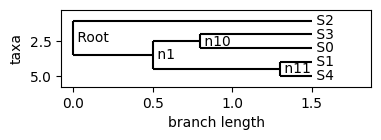

Original likelihood: 1.0125399560773526e-17
Proposed alpha 0.13
Chosen node: n11
Rescale by 0.9099122021982557
New likelihood: 8.619739310619711e-18
Acceptance ratio: 0.8512986829688338
New tree accepted


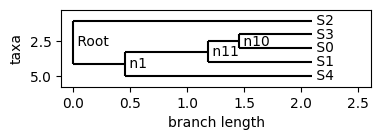

In [177]:
def NNI_generate_tree(tree, alpha, chosen_node, new_nodes):
    print(f"Chosen node: {chosen_node}")
    new_tree = copy.deepcopy(tree)
    new_tree.alpha = alpha
    for clade in new_tree.get_nonterminals():
        if clade.name == chosen_node.name:
            clade.clades = new_nodes[:2]
            if new_tree.parents.get(clade) != new_tree.root: 
                parent_node = new_tree.parents.get(clade)
                parent_node.clades = [clade, new_nodes[2]]
            elif new_tree.parents.get(clade) == new_tree.root:
                sibling = new_tree.siblings.get(clade)
                niblings = new_tree.children.get(sibling)
                sibling.clades = [new_nodes[2], niblings[1]]
    new_tree.children = new_tree.dict_children()
    new_tree.parents = new_tree.dict_parents()
    new_tree.siblings = new_tree.dict_siblings()
    new_tree.adjust_branch_lengths()
    return new_tree

print(tree)
tree.draw(figsize=(4,1))
tree.likelihood = tree.calculate_likelihood()
print(f"Original likelihood: {tree.likelihood}")

for i in range(2):
    # alpha = np.random.uniform(0.05,0.15)
    # alpha = 0.1
    print(f"Proposed alpha {alpha}")
    new_nodes = copy.deepcopy(permutable[-(i+1):] + permutable[:-(i+1)]) # copy is needed otherwise I am referring to nodes in the original tree
    new_tree = NNI_generate_tree(tree, alpha, chosen_node, new_nodes)
    r = np.random.uniform(0.8, 1.2)
    print(f"Rescale by {r}")
    for clade in new_tree.find_clades():
        if clade.branch_length:
            clade.branch_length *= r
    
    # print(new_tree)
    
    new_tree.likelihood = new_tree.calculate_likelihood()
    print(f"New likelihood: {new_tree.likelihood}")
    rho = np.min([1, new_tree.likelihood / tree.likelihood])
    print(f"Acceptance ratio: {rho}")
    if np.random.random() < rho:
        print("New tree accepted")
        updated_tree = copy.deepcopy(new_tree)
        updated_tree.draw(figsize=(4,1))
        break
    else:
        print("New tree rejected")
        updated_tree = copy.deepcopy(tree)
    new_tree.draw(figsize=(4,1))

    # I use a Metropolis-Hastings strategy, so I construct the first tree, then its acceptance ratio, and if passed, I accept it, otherwise I generate the second tree and repeat. If both are rejected, I keep the original tree. 

In [ ]:
tree.draw()

In [ ]:
print(tree)
tree.draw(figsize=(4,1))
seq_len = len(tree.get_terminals()[0].sequence)
alpha = 0

taxa_names = [node.name for node in tree.get_terminals()]
random_tree = Phylogenetic_Tree(seq_len, alpha).generate_random_tree(taxa_names=taxa_names, generate_sequences=False)
for i, node in enumerate(random_tree.get_terminals()):
    node.sequence = tree.get_terminals()[i].sequence
    node.index = sequence_to_index(node.sequence)
print(random_tree)
random_tree.likelihood = random_tree.calculate_likelihood()
random_tree.draw(figsize=(4,1))

In [ ]:
NNI_nodes = get_NNI_nodes(random_tree)
print(f"The internal edges: {[node.name for node in NNI_nodes]}")

chosen_node = random.choice(NNI_nodes)
print(f"Chosen node: {chosen_node}")

permutable = permutable_nodes(random_tree, chosen_node)
print(f"Nodes to be permuted: {[node.name for node in permutable]}")

permutable_1 = permutable[-1:] + permutable[:-1]
permutable_2 = permutable[-2:] + permutable[:-2]
permutables = [permutable_1, permutable_2]

print(f"Original likelihood: {random_tree.likelihood}")

tree.draw(figsize=(4,1))

for i in range(2):
    new_tree = copy.deepcopy(tree)
    for clade in new_tree.get_nonterminals():
        if clade.name == chosen_node.name:
            clade.clades = permutables[i][:2]
            if new_tree.parents.get(clade) != new_tree.root: 
                parent_node = new_tree.parents.get(clade)
                parent_node.clades = [clade, permutables[i][2]]
            elif new_tree.parents.get(clade) == new_tree.root:
                sibling = new_tree.siblings.get(clade)
                niblings = new_tree.children.get(sibling)
                sibling.clades = [permutables[i][2], niblings[1]]
    # Update family relationships
    new_tree.children = new_tree.dict_children()
    new_tree.parents = new_tree.dict_parents()
    new_tree.siblings = new_tree.dict_siblings()
    
    # Metropolis step
    new_tree.likelihood = new_tree.calculate_likelihood()
    print(f"New tree likelihood: {new_tree.likelihood}")
    rho = np.min([1, new_tree.likelihood / tree.likelihood])
    print(f"Acceptance ratio: {rho}")
    if np.random.random() < rho:
        print("New tree accepted")
        updated_tree = copy.deepcopy(new_tree)
        break
    else:
        print("New tree rejected")
        updated_tree = copy.deepcopy(random_tree)
    new_tree.draw(figsize=(4,1))

    # I use a Metropolis-Hastings strategy, so I construct the first tree, then its acceptance ratio, and if passed, I accept it, otherwise I generate the second tree and repeat. If both are rejected, I keep the original tree. 

In [ ]:
# permutable_1 = permutable[-1:] + permutable[:-1]
# permutable_2 = permutable[-2:] + permutable[:-2]
# permutables = [permutable_1, permutable_2]

# import copy

# new_tree_1 = copy.deepcopy(tree)
# new_tree_2 = copy.deepcopy(tree)
# tree_list = [new_tree_1, new_tree_2]

# print(chosen_node)

# tree.draw(figsize=(4,1))

# for i, new_tree in enumerate(tree_list):
#     for clade in new_tree.get_nonterminals():
#         if clade.name == chosen_node.name:
#             clade.clades = permutables[i][:2]
#             if new_tree.parents.get(clade) != new_tree.root: 
#                 parent_node = new_tree.parents.get(clade)
#                 parent_node.clades = [clade, permutables[i][2]]
#             elif new_tree.parents.get(clade) == new_tree.root:
#                 sibling = new_tree.siblings.get(clade)
#                 niblings = new_tree.children.get(sibling)
#                 sibling.clades = [permutables[i][2], niblings[1]]
#     # Update family relationships
#     new_tree.children = new_tree.dict_children()
#     new_tree.parents = new_tree.dict_parents()
#     new_tree.siblings = new_tree.dict_siblings()
#     new_tree.draw(figsize=(4,1))

#     # I use a Metropolis-Hastings strategy, so I construct the first tree, then its acceptance ratio, and if passed, I accept it, otherwise I generate the second tree and repeat. If both are rejected, I keep the original tree. 

In [ ]:
def generate_random_taxa_names(n_taxa, from_alphabet=False):
    if from_alphabet:
        alphabet = string.ascii_uppercase
        n_alphabet = len(alphabet)
        iter = int(np.ceil(np.emath.logn(n_alphabet, n_taxa)))
        keywords = [''.join(i) for i in product(alphabet, repeat=iter)]
        random_taxa_names = random.sample(keywords, k=n_taxa)
    else:
        random_taxa_names = [f"S{i}" for i in range(n_taxa)]


In [ ]:
# # Changes to insert in commit:
# Construction of a Nearest-Neighbor interchange (NNI) searcher
# Removed get_parent_node function
# Modified some methods to return an object instead of simply defining a class attribute
# Added siblings dictionary
# Eliminated generate_random_taxa_names
# Eliminated return_idx in sequence generation function and child generation function
# Eliminated remove and attach internal names functions